Visualizing GPT4 Reshuffle test.json


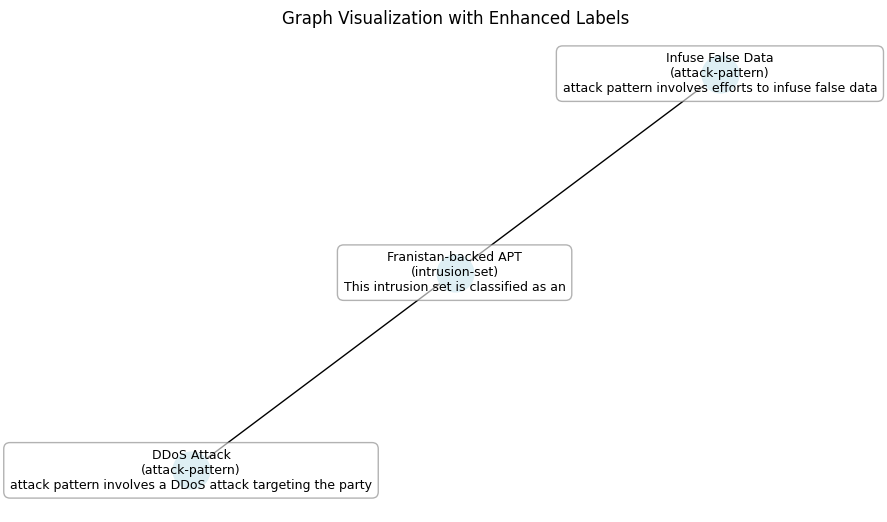

Visualizing GPT4 Reshuffle test2.json


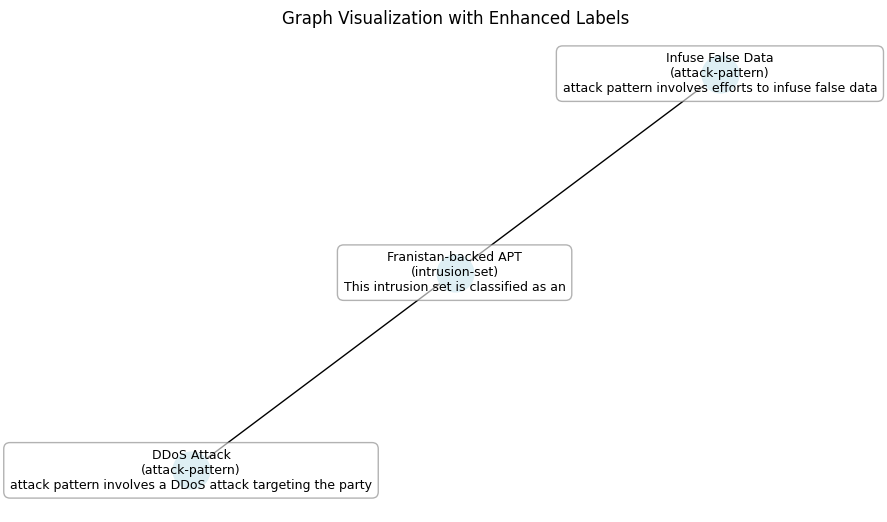

Visualizing GPT4 Reshuffle test3.json


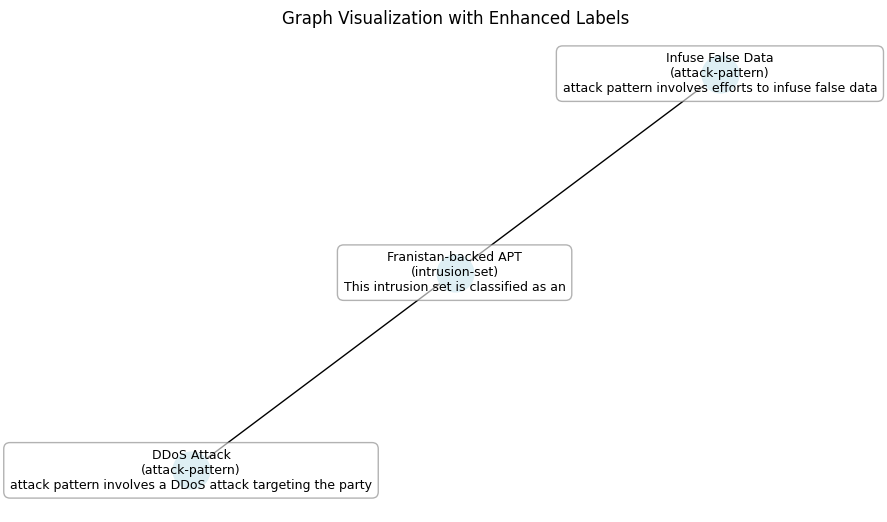

Visualizing Verbatim test.json


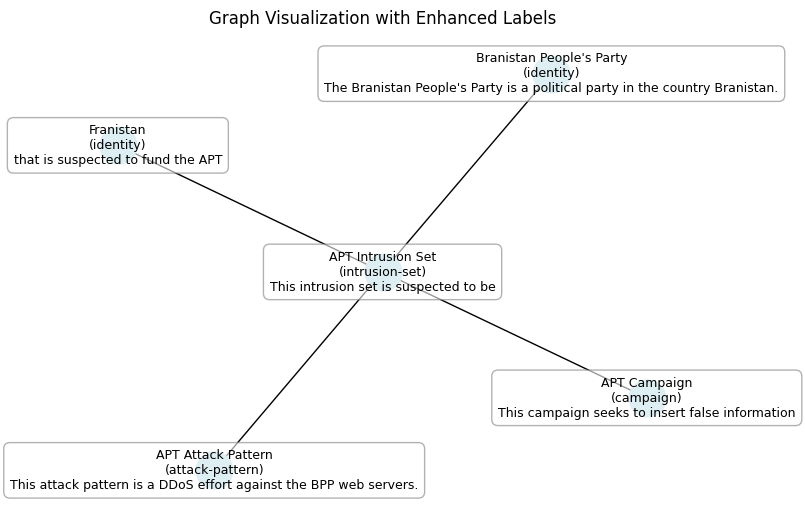

Visualizing Verbatim test2.json


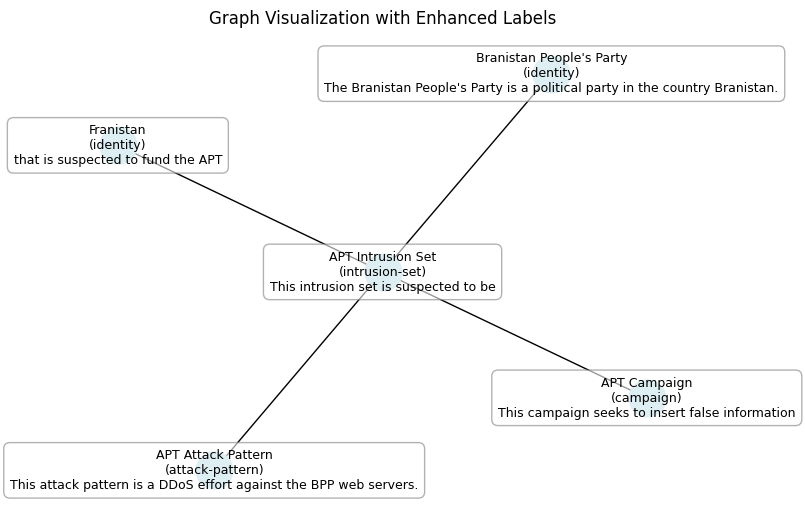

Visualizing Verbatim test3.json


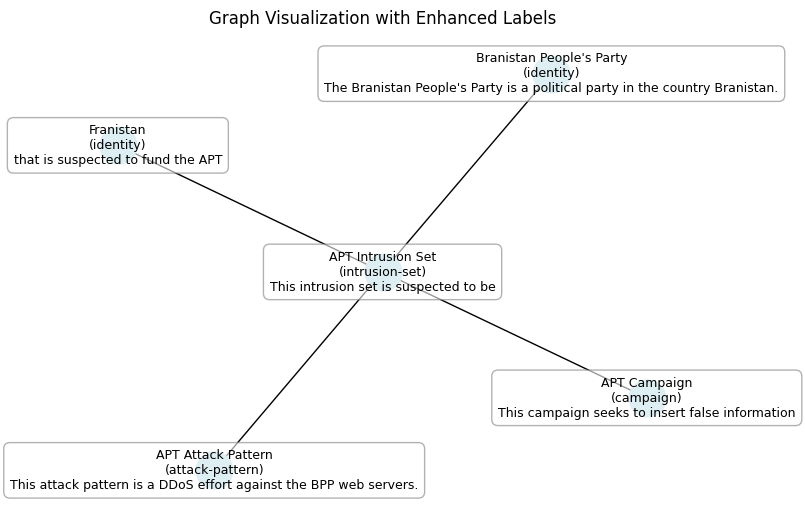

In [5]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load the spaCy NLP model
nlp = spacy.load('en_core_web_sm')

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def create_graph_from_json(json_data):
    """Create a networkx graph from custom JSON data that includes types and relationships."""
    G = nx.Graph()
    id_attr_map = {}
    
    # First pass to create nodes with more details
    for item in json_data:
        if item['type'] != 'relationship':
            node_attributes = {
                'type': item.get('type', ''),
                'name': item.get('name', ''),
                'description': item.get('description', ''),
                'aliases': ', '.join(item.get('aliases', [])),
                'goals': ', '.join(item.get('goals', [])),
                'resource_level': item.get('resource_level', ''),
                'primary_motivation': item.get('primary_motivation', '')
            }
            G.add_node(item['id'], **node_attributes)
            id_attr_map[item['id']] = item
    
    # Second pass to create edges based on relationships
    for item in json_data:
        if item['type'] == 'relationship':
            if item['source_ref'] in id_attr_map and item['target_ref'] in id_attr_map:
                G.add_edge(item['source_ref'], item['target_ref'], relationship_type=item.get('relationship_type', ''))

    return G

def extract_verb_centered_snippet(description, window=2, max_gap=4):
    """Extract snippets around the first two verbs found in the description, handling proximity."""
    doc = nlp(description)
    verbs = []
    
    # Identify all verbs and their positions
    for token in doc:
        if token.pos_ == 'VERB':
            verbs.append((token.i, token))
        if len(verbs) == 2:  # Stop after collecting two verbs
            break
    
    if not verbs:
        return description  # Return original if no verbs are found

    if len(verbs) == 1:
        # Only one verb found, return the snippet around it
        start = max(0, verbs[0][1].i - window)
        end = min(len(doc), verbs[0][1].i + window + 1)
        return doc[start:end].text

    # If two verbs are found, check their proximity
    v1, v2 = verbs
    if (v2[0] - v1[0]) <= max_gap:
        # Verbs are close enough, return a single continuous snippet
        start = max(0, v1[1].i - window)
        end = min(len(doc), v2[1].i + window + 1)
        return doc[start:end].text
    else:
        # Verbs are far apart, return snippets with ellipses
        snippet1 = doc[max(0, v1[1].i - window):v1[1].i + window + 1].text
        snippet2 = doc[max(0, v2[1].i - window):v2[1].i + window + 1].text
        return f"{snippet1} ... {snippet2}"

def visualize_graph(G):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    pos = nx.spring_layout(G, seed=42)  # Use a seed for reproducible layout
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=700, font_size=12)

    # Custom labels with more detailed attributes formatted in a readable way
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data['name']}\n({data['type']})"
        if 'description' in data:
            snippet = extract_verb_centered_snippet(data['description'])
            label += f"\n{snippet}"
        labels[node] = label

    # Draw custom labels with bounding boxes for better readability
    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization with Enhanced Labels')
    plt.show()

def process_json_file(file_path):
    """Process a single JSON file and visualize its graph."""
    json_data = load_json(file_path)
    graph = create_graph_from_json(json_data)
    print(f"Visualizing {os.path.basename(file_path)}")
    visualize_graph(graph)

def main(input_path):
    """Process JSON files from a directory or a single JSON file."""
    if os.path.isdir(input_path):
        json_files = [os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.json')]
        for json_file in json_files:
            process_json_file(json_file)
    elif os.path.isfile(input_path) and input_path.endswith('.json'):
        process_json_file(input_path)
    else:
        print("Provided path is neither a directory nor a valid JSON file.")

if __name__ == "__main__":
    path = input("Enter the directory path or JSON file path: ")
    main(path)
